In [6]:
import numpy as np

from poolData import protein, interactionList, pooledDataset, proteinProteinMatrix
from poolSolver import subsetSelectionProteinSolvers
from poolSolver import poolSolver
from poolSimulator import poolSimulator
import importlib
importlib.reload(poolSimulator)

import matplotlib.pyplot as plt

In [ ]:
##############################
# Figure 1b: plot mixing matrix, 
# signal vectors and 
# reconstructed pulldown vectors
################################


#Loads the design matrix
designFile= "standardizedData/20250404_PooledIP_15x30/20250404_PooledIP_15x30.mixingMatrix.tsv"
(baits, mixing) = pooledDataset.pooledDataset.readMixingMatrix(designFile)

#Normalizes the pools to have max=1
mixing=(mixing.T/np.max(mixing, axis=1)).T


#Builds a pool solver object
sim = poolSimulator.poolSimulator(mixing, baits)

#Builds the ground-truth protein-protein interaction matrix
np.random.seed(1)
sim.buildBernoulliPPIMatrix(20,0.03)

#Sets a ground truth PPI matrix for plotting purposes
(iProt, iBait) = (17, 8)
sim.groundTruthPPIs.matrix[iProt] =  np.zeros(sim.groundTruthPPIs.matrix.shape[1])
sim.groundTruthPPIs.matrix[iProt, iBait] = 1

# Simulates the experiment with a specified noise level
sim.simulateExperiment(noiseSD=0.2, noiseType="normal_nonneg")

#Solves the experiment
nnls_bss = subsetSelectionProteinSolvers.NNLSBestSubsetSelectionProteinSolver(sim.syntheticData, stopping_criteria=5, model='F_global', maxSize=4)
ppiMatrix = poolSolver.parallelPoolSolver(sim.syntheticData,nnls_bss).solveExperiment()

#ppiMatrix.plotCombinedMixSignalBetaPlot(imageScale=0.25, trainingData=sim.syntheticData, ppiAnnotations= [])
#ppiMatrix.plotCombinedMixSignalBetaPlot(imageScale=0.25, trainingData=sim.syntheticData, ppiAnnotations= sim.groundTruthAnnotations)
ppiMatrix.removeColumns([0]).plotCombinedMixSignalBetaPlot(imageScale=0.25, trainingData=sim.syntheticData, ppiAnnotations=[], sigThreshold=None, mixingIndices=range(len(mixing[0])))

plt.show()

In [ ]:
########################################
#Figure 1b: plot correlation between
# mixing and signal vectors for Protein 19 
# with Ab 9 and Ab 22
#########################################



#correlation with Ab 9
iProt = 18
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4, 1.5))


yMix=sim.mixingMatrix[:,iBait]
ySig=sim.syntheticData.signalMatrix[iProt]
x = range(len(yMix))
#coeffs = np.polyfit(x, y, 1)  # 1 means linear
#fit_line = np.polyval(coeffs, x)
corr_coef = np.corrcoef(yMix, ySig)[0, 1]
axs[0].plot(x, ySig, 'o', color=ppiMatrix.cSig, linestyle='-')
axs[0].plot(x, yMix, 'o', color=ppiMatrix.cMix, linestyle='-')
#axs[0].plot(x, fit_line, color='black', linestyle='--', label='Linear fit')
axs[0].set_title(f'Protein {iProt+1} vs. AB {iBait+1}')
axs[0].set_xlabel(f'Pools')
axs[0].set_ylabel(f'Signal\n(protein {iProt+1})')
axs[0].set_xticks([])
axs[0].text(0.05, 0.95, f'r = {corr_coef:.2f}', transform=axs[0].transAxes,
            verticalalignment='top', horizontalalignment='left', fontsize=10, bbox=dict(facecolor='white', alpha=0.0, edgecolor='none'))




#correlation with Ab 22
iBaitOff=21
yMix=sim.mixingMatrix[:,iBaitOff]
ySig=sim.syntheticData.signalMatrix[iProt]
x = range(len(yMix))
#coeffs = np.polyfit(x, y, 1)  # 1 means linear
#fit_line = np.polyval(coeffs, x)
corr_coef = np.corrcoef(yMix, ySig)[0, 1]
axs[1].plot(x, ySig, 'o', color=ppiMatrix.cSig, linestyle='-')
axs[1].plot(x, yMix, 'o', color=ppiMatrix.cMix, linestyle='-')
axs[1].set_title(f'Protein {iProt+1} vs. AB {iBaitOff+1}')
#axs[0].plot(x, fit_line, color='black', linestyle='--', label='Linear fit')
#axs[1].set_xlabel(f'Conc. (AB {iBaitOff+1})')
axs[1].set_yticks([])
axs[1].set_xticks([])
axs[1].text(0.05, 0.95, f'r = {corr_coef:.2f}', transform=axs[1].transAxes,
            verticalalignment='top', horizontalalignment='left', fontsize=10, bbox=dict(facecolor='white', alpha=0.0, edgecolor='none'))


plt.show

In [ ]:
#####################################
# Figure 1c: Solve Protein 16 using Pool Solver
###########################################

iPlot=15
Fcut=5
iBest=0
y=sim.syntheticData.signalMatrix[iPlot]
fullOutput=nnls_bss.solveProtein(y, fullOutput=True)
#Plots:
betaMatrix=np.zeros((len(fullOutput["modelList"]), nnls_bss.design_matrix.shape[1]))
for (iModel, model) in enumerate(fullOutput["modelList"]):
    print(f'Model {iModel}, Indices: {model["indices"]}, Betas: {model["betas"]}, RSS: {model["RSS"]}')
    if iModel >0:
        (RSS1, RSS2) = ( fullOutput["modelList"][iModel-1]["RSS"], fullOutput["modelList"][iModel]["RSS"] )
        (df1,  df2)  = ( fullOutput["modelList"][iModel-1]["p"],   fullOutput["modelList"][iModel]["p"] )
        F = ((RSS1-RSS2)/(df2-df1))/(RSS2/(len(y) - df2))
        print(f"    F-statistic for model {iModel}: {F}, RSS1: {RSS1}, RSS2: {RSS2}, df1: {df1}, df2: {df2}, n: {len(y)}")
        if F>Fcut:
                iBest = iModel
    for (iCoef, iCol) in enumerate(model["indices"]):
        betaMatrix[iModel, iCol] = model["betas"][iCoef]
# Plots models
modelNames=[protein.protein(f'Model {i}',[]) for i in range(len(fullOutput["modelList"]))]
betaPPMatrix=proteinProteinMatrix.proteinProteinMatrix(betaMatrix, modelNames, ppiMatrix.columnProteins, [])
betaPPMatrix.plotCombinedMixSignalBetaPlot(imageScale=0.25)
print(f"Best model: {iBest}")

print("> Exclusion:")
iBest=3
betaExclusionMatrix = np.array(fullOutput["modelList"][iBest]["beta_exclusion"])
#exclusionNames=[protein.protein(f'Exclusion {i}',[]) for i in range(len(betaExclusionMatrix))]
exclusionNames = [ ppiMatrix.columnProteins[i] for i in fullOutput['indices']]
betaExclusionPPMatrix=proteinProteinMatrix.proteinProteinMatrix(betaExclusionMatrix, exclusionNames, ppiMatrix.columnProteins, [])
betaExclusionPPMatrix.plotCombinedMixSignalBetaPlot(imageScale=0.25)

In [19]:
#Figure 1c: print RSS and F values to obtain signifcance of each PPI
#NOTE: Set iBest according to results

iBest=3
for iExclude in fullOutput["modelList"][iBest]['indices']:
    rssBase = fullOutput["modelList"][iBest]["RSS"]
    rrsExl = fullOutput['modelList'][iBest]['RSS_exclusion'][iExclude]
    p = fullOutput["modelList"][iBest]["p"]
    n = len(y)
    print(f"Exclusion {iExclude}: RSS = {rrsExl}, F-statistic = {(rrsExl - rssBase)/(rssBase/(n - p))}")
    

Exclusion 2: RSS = 0.31292686007950365, F-statistic = 3.5094065745391676
Exclusion 4: RSS = 1.6437281686360317, F-statistic = 69.46711490001836
Exclusion 17: RSS = 2.3713418436117824, F-statistic = 105.52939575224829


> Loads and processes the design matrix
> Builds the simulations
> Builds the solvers
> Solves the diagonal simulations


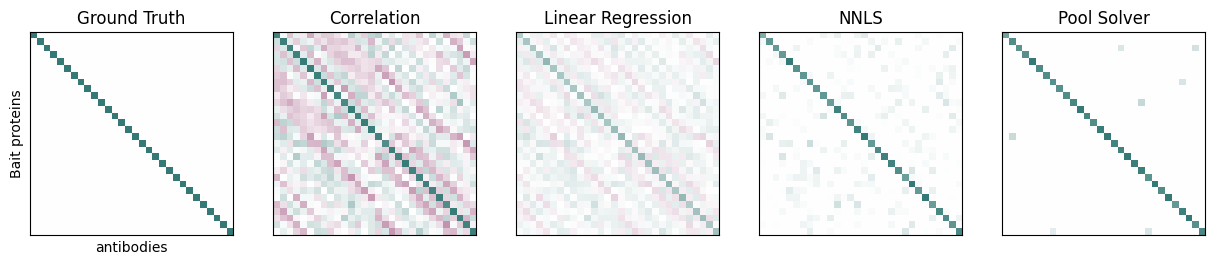

In [26]:
#############################
# Figure 1d: Solve simulated 
# ground truth data using
# correlation, linear regression
# NNLS and the Pool Solver
#############################


print("> Loads and processes the design matrix")
designFile="standardizedData/20250404_PooledIP_15x30/20250404_PooledIP_15x30.mixingMatrix.tsv"
(baits, mixing) = pooledDataset.pooledDataset.readMixingMatrix(designFile)
mixing=(mixing.T/np.max(mixing, axis=1)).T #Normalizes the pools to have max=1
nProts=mixing.shape[1]

print("> Builds the simulations")
noiseSD=0.2
#Builds diagonal simulation with a specified noise level
sim_diag = poolSimulator.poolSimulator(mixing, baits)
sim_diag.buildDiagonalPPIMatrix()
sim_diag.simulateExperiment(noiseSD=noiseSD, noiseType="normal_nonneg")

print("> Builds the solvers")
sigThreshold = 10
solver_cor = poolSolver.correlationSolver(sim_diag.syntheticData)
solver_ls  = poolSolver.leastSquaresSolver(sim_diag.syntheticData)
solver_nnls = poolSolver.nnlsSolver(sim_diag.syntheticData)
solver_bss = subsetSelectionProteinSolvers.NNLSBestSubsetSelectionProteinSolver(sim_diag.syntheticData, stopping_criteria=sigThreshold, model='F_global', maxSize=5)

print("> Solves the diagonal simulations")
ppiMatrix_diag_cor  = poolSolver.parallelPoolSolver(sim_diag.syntheticData, solver_cor ).solveExperiment()
ppiMatrix_diag_ls   = poolSolver.parallelPoolSolver(sim_diag.syntheticData, solver_ls  ).solveExperiment()
ppiMatrix_diag_nnls = poolSolver.parallelPoolSolver(sim_diag.syntheticData, solver_nnls).solveExperiment()
ppiMatrix_diag_bss  = poolSolver.parallelPoolSolver(sim_diag.syntheticData, solver_bss ).solveExperiment()

#Plots the ppi matrices as row of rasters
scale=2.5
fig, axs = plt.subplots(1, 5, figsize=(5*scale, 1*scale))

#Plots Diagonal PPI simulation
sim_diag.groundTruthPPIs.plotBetaHeatmap(axs[0], highlightBaits=False, sigThreshold=None)
axs[0].set_title("Ground Truth")
ppiMatrix_diag_cor.removeColumns([0]).plotBetaHeatmap(axs[1], highlightBaits=False, sigThreshold=None)
axs[1].set_title("Correlation")
ppiMatrix_diag_ls.removeColumns([0]).plotBetaHeatmap(axs[2], highlightBaits=False, sigThreshold=None)
axs[2].set_title("Linear Regression")                    
ppiMatrix_diag_nnls.removeColumns([0]).plotBetaHeatmap(axs[3], highlightBaits=False, sigThreshold=None)
axs[3].set_title("NNLS")
ppiMatrix_diag_bss.removeColumns([0]).plotBetaHeatmap(axs[4], highlightBaits=False, sigThreshold=None)
axs[4].set_title("Pool Solver")
axs[0].get_yaxis().set_visible(True)
axs[0].get_xaxis().set_visible(True)
axs[0].set_yticks([])
axs[0].set_xticks([])
axs[0].set_ylabel("Bait proteins")
axs[0].set_xlabel("antibodies")

plt.tight_layout()